# Cellular automata models

Cellular automata (CA) is one of the prime examples of artificial life, as well as the emergence of complex structures at the systemic level from simple interactions between the individual parts of the system. Moreover, CA are defined iteratively over time, and manifest such complex properties even when their definition is fully deterministic.

CA was invented by Von Neumann in the 1940s to study crystallography. It has lots of applications in modelling biological systems and beyond.

In [13]:
import numpy as np

## Conway's game of life

### Model
Our model consists of a board of size $l\times l$, with _discrete_ cells, that can only take two values: alive ($1$) or not alive ($0$). We refer to the set of all possible combinations of cells of size $l$ as $\mathbb{B}_l$   

The cells do not move, but they evolve in time, according to their neighbours.
Let $X_{ij}(t)$ denote the value of the cell at coordinates $(i, j)$ at time $t$.

If there are too few (<2) or too many (>3) other living cells around a living cell, then it dies. Otherwise, a neighbourhood of exactly three living cells can birth a new cell in an empty space. 

Let $\mathcal{N}_{ij}$ be the neighbourhood of cell $(i, j)$. We define the size of the living neighbourhood as 
$$
\texttt{size}_{ij}(t) = |\{ x \in \mathcal{N}_{ij} \: | \: x = 1 \}|
$$
where $|\cdot|$ is the number of elements in the set. 



We can express this as an mathematical iteration rule:
$$
X_{ij}(t+1) = \begin{cases}
0 & \textsf{ if } (X_{ij}(t) = 1) \textsf{ and } (\texttt{size}_{ij}(t) > 3) \textsf{ or } (\texttt{size}_{ij}(t) < 2) \\
1 & \textsf{ if } (X_{ij}(t) = 0) \textsf{ and } (\texttt{size}_{ij}(t) = 3) \\
X_{ij}(t) & \textsf{otherwise}
\end{cases}
$$


## Implementation

### World
We represent the world as a `numpy` array of shape `(l, l)` and initialise it randomly with living and dead cells. 

We use the parameter `seed` to make the simulation reproducible, and `p` to specify the probability that a cell is alive in the initial configuration of the board.

In [5]:
def init(seed, l, p):
    """
    Returns a board
    """
    np.random.seed(seed)
    return np.random.choice([0, 1], l * l, p = [1 - p, p]).reshape(l, l)
    

####  Neighbours
To reason about the model and implement the simulation we need to consider a few things about the geometry of this board.
Above we have defined a neighbourhood that's also known as a Moore neighbourhood (in red). These are the 2 horizontal, 2 vertical, and 4 diagonal immediate neighbours.

Alternatively, the Von Neumann neighbourhood (in blue) consists instead only of horizontal and vertical neighbours, but 2 neighbours are taken in each direction, so the neighbourhood size is the same with the Moore neighbourhood.

![](images/neighs.jpg)

What do you think happens to the model when the neighbourhood changes?

#### Boundaries
The space is finite, so we need to decide how how to define neighbours at the boundary. The most frequent type of boundary when exploring models of complex physical systems are periodic boundaries, i.e. wrap-around bounds. So the neighbours of $(0, 0)$ are, besides $(0, 1), (1, 1), (1, 0)$, also $(0, l-1), (l-1, 0), (l-1, l-1), (l-1, 1), (1, l-1)$.

The simplest way to implement this is with modular arithmetic.

In [6]:
def moore_neighbours(state, pos):
    i, j = pos
    l, _ = state.shape
    neighs = [ state[ i        , (j-1) % l ], state[ i        , (j+1) % l ],
               state[ (i-1) % l, j         ], state[ (i+1) % l, j         ],
               state[ (i-1) % l, (j-1) % l ], state[ (i-1) % l, (j+1) % l ],
               state[ (i+1) % l, (j-1) % l ], state[ (i+1) % l, (j+1) % l ]
             ]
    return neighs

### Evolution
The world evolves in discrete time steps, and the evolution rule is a function that takes a world and returns a world. 

In mathematical notation, we write iteration rules like this:
$$
X(t+1) = f(X(t))
$$
where $X(t), X(t+1) \in \mathbb{B}_l$ and $f : \mathbb{B}_l \rightarrow \mathbb{B}_l$.

As this is a function that takes and returns the same type of data we can perform chained computation:

$$ X(t+n) = f(f... f(X(t)) \textsf{ (applied }n\textsf{ times) } \Leftrightarrow \\
 X(t+n) = f^n(X(t))$$

We should consider also _keeping system history_ in order to analyse trajectories in time.

In [7]:
def evolve(state):
    new  = state.copy()
    l, _ = state.shape
 
    for i in range(l):
        for j in range(l):
            total = sum(moore_neighbours(state, (i, j)))
            if state[i, j]:
                if (total < 2) or (total > 3):
                    new[i, j] = 0
            else:
                if total == 3:
                    new[i, j] = 1
    return new

In [8]:
def evolve_n(state, n):
    history = [ state.copy() ]

    while n:
        new = evolve(state)
        history.append(new)
        state[:] = new[:]
        n = n-1
    return history

### Visualisation
Finally, let's add a function to plot the states we have been drawing, we use the `imshow` function in `matplotlib`, often used to display 2D arrays with ranges of values.

Moreover we will use `matplotlib`'s `animation` module, which takes a function, say `genframe` and applies it iteratively on some input state with some parameters. The first parameter of this  must always be an integer which is indexing the frame in the animation, while the second parameter must be the same as the return type of `genframe`, namely an image.  

In [9]:
import matplotlib.animation as animation
from matplotlib.image import AxesImage
import matplotlib.pyplot as plt
from IPython.display import Video

In [10]:
def genframe(num, img, state):
    new = evolve(state)
    img.set_data(new * 255)
    state[:] = new[:]
    return img,

def animate(state, filename):
    fig, ax = plt.subplots()
    initimg = ax.imshow(state, interpolation='nearest')
    ani     = animation.FuncAnimation(fig, genframe, fargs=(initimg, state, ),
                                      frames = steps,
                                      interval = 50)
 
    ani.save(filename, fps = 12, extra_args = ['-vcodec', 'libx264'])

Since `genframe` calls the `update` function for the system, our system evolves over time as each frame of the animation is generated. 

Below is a video created by running the code.
Even with these very simple rules, the system manifests complex patterns from the collective behaviour of many cells. These patterns manifest in space - by having certain groups of cells showing organised movement - or in time - by certain groups oscillating between two states or staying in the same state.

In [14]:
l = 50
steps = 100
seed = 999
p = 0.5
initial = init(seed, l, p)

animate(initial, f"video/conway_l{l}_p{p}_{seed}.mov")

In [12]:
Video(f"video/conway_l{l}_p{p}_{seed}.mov")

Here are a few of the most famous configurations (from Wikipedia). A huge community of people exists researching these - a lot like biologists looking for new species in nature :)

Pulsar | Heavy Spaceship (HWSS) | Glider gun | Breeder 
-|-|-|-
![](images/pulsar.gif) | ![](images/hwss.gif) | ![](images/glider_gun.gif) | ![](images/breeder.gif)
-|-|-|-

## Exercise
Create an initial board with one of these specific configurations.
Find out how the configuration evolves in the long time limit - does is stay the same, oscillate, or dissapear?

E1 | E2 | E3
-|-|-
 ![](images/loaf.png) | ![](images/diehard.png) | ![](images/acorn.png)
-|-|-

## Experiment

An interesting phenomenon in some complex systems is chaos, or extreme sensitivity to initial conditions. Imagine a single cell is flipped in the initial state, and we explore what happens after $t=10$ has elapsed between the two:

In [11]:
seed = 1337
p = 0.5
steps = 10

initial_1 = init(seed, l, p)
initial_2 = initial_1.copy()
initial_2[1,1] = 1 - initial_2[1,1]

history_1 = evolve_n(initial_1, steps)
history_2 = evolve_n(initial_2, steps)

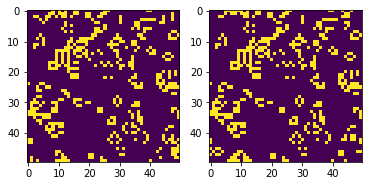

In [12]:
fix, axs = plt.subplots(ncols = 2, nrows = 1)
axs[0].imshow(history_1[-1] * 255)
axs[1].imshow(history_2[-1] * 255)
plt.show()

In [13]:
diff = np.logical_xor(history_1[-1], history_2[-1])
plt.imshow(diff)

Let's now consider we are running an experiment based on this model. We are interested in exploring how full does the board need to be in order to sustain life. The parameter we explore is the probability of a living cell in the initial state. We can formulate our research question as: what is the optimal proportion of living cells in a system to sustain life for at least 100 steps?

In order to check that life is being sustained, we can `sum` over the whole board and obtain the number of living cells. For example, we can compare the number of living cells over time in the two simulations above:

In [27]:
times = range(steps+1)
times
nums_1 = [ np.sum(h) for h in history_1 ]
nums_2 = [ np.sum(h) for h in history_2 ]
nums_1

plt.plot(times, nums_1, label = 'Simulation 1', alpha = 0.5)
plt.plot(times, nums_2, label = 'Simulation 2', linestyle = '-')
plt.legend()
plt.show()

### Your methodology

Peform a parameter search for $p$. First set $p=0.1$ and increment it by amounts of $0.1$. Run a number of simulations (say N=20) for each $p$ with different seeds. 

_can you formulate a clear hypothesis you'd like to test?_

_what about l?_

#### Task 1
For each simulation for each $p$, count the living cells over time and identify trends - is the number increasing, decreasing, constant, or oscillating around the value?

Visualise your results for t = 0, 1, ... 100.

Extract statistics from your results: average number of living cells (`np.mean`) and error (standard deviation, `np.std()`) across all simulations with that $p$.

Can you relate these statistics to $p$ and system size $l$?

#### Task 2
How long does it take for a system that cannot sustain life to die?

### Resources

The code in this notebook is available in pure Python [here](https://pastebin.com/w56KvdwZ). 

![](images/code_url_qr.png)
